# 残差网络实验

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 设置中文支持
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 车辆分类数据集准备

In [20]:
# 构建数据集对象
class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        
        # 将传入目录下的文件名转换为列表
        self.classes = os.listdir(data_folder)    # ['bus', 'car', 'truck']
        # 建立类别索引
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # {'bus': 0, 'car': 1, 'truck': 2}
        # 数据成员变量，其元素均为元组数据类型，每一个元组构成为（图像路径名，类别索引）
        self.data = self.load_data()
        # 对数据进行打乱
        random.shuffle(self.data)

    def load_data(self):
        data = []
        for cls_name in self.classes:
            # 按类别获取图像文件夹的路径
            cls_folder = os.path.join(self.data_folder, cls_name)
            # 过滤文件后缀并存储同类图像的路径为列表
            images = [os.path.join(cls_folder, img_name) for img_name in os.listdir(cls_folder) if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
            # 获取该类图像的类别索引
            class_idx = self.class_to_idx[cls_name]
            # 将可迭代的列表添加到data中
            data.extend([(img_path, class_idx) for img_path in images])
        
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_idx = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, class_idx

# Data folder path
data_folder = r"Datasets\CarClassificationDatasets"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CustomDataset(data_folder, transform=transform)
# 划分数据集
total_samples = len(dataset)
train_samples = int(0.7 * total_samples)
test_samples = total_samples - train_samples

# 划分训练集和测试集
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_samples, test_samples])

# 定义batch_size
batch_size = 32

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练集大小：", len(train_dataset))
print("测试集大小：", len(test_dataset))

训练集大小： 949
测试集大小： 408


0
2
1
2
1


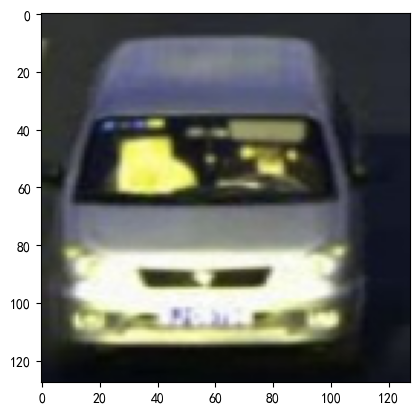

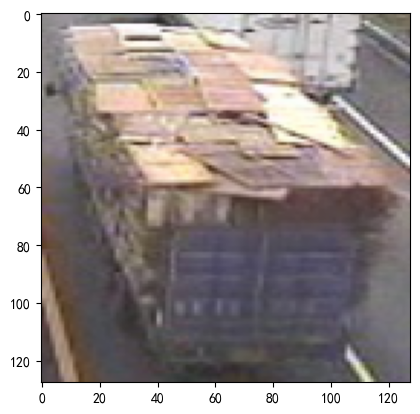

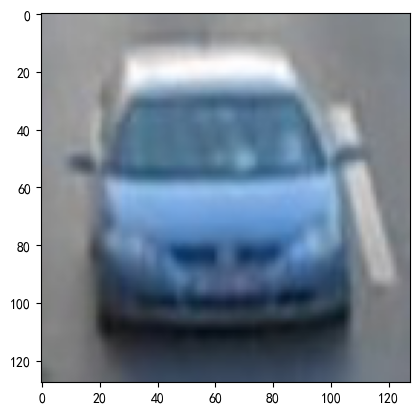

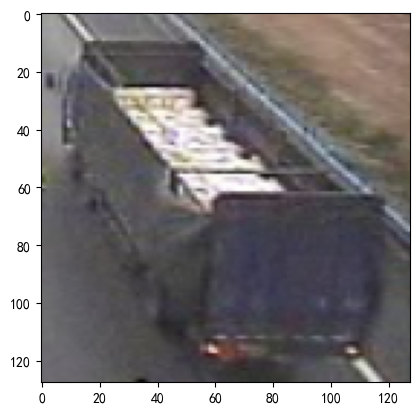

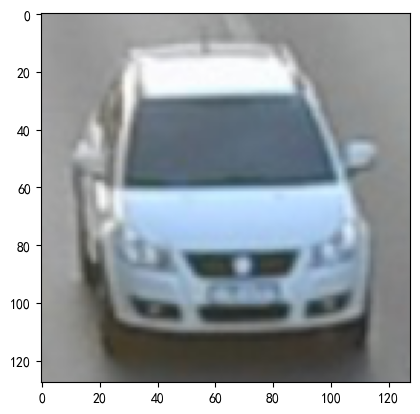

In [21]:
# 验证数据集分类正确性
for i in range(5):
    plt.figure()
    print(train_dataset[i+34][1])
    plt.imshow(transforms.ToPILImage()(train_dataset[i+34][0]))

plt.show()

## 函数准备

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 绘图函数

In [25]:
# 定义绘图函数

# 绘制训练损失和测试损失的函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label="train loss", color="red", marker='v', markersize=5, linewidth=2)
    plt.plot(x, test_loss, label="test loss", color="blue", marker='o', markersize=5, linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 绘制训练损失和测试损失的函数
def plot_acc(train_acc, test_acc, title):
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label="train acc", color="red", marker='v', markersize=5, linewidth=2)
    plt.plot(x, test_acc, label="test acc", color="blue", marker='o', markersize=5, linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()


### 模型训练函数

In [24]:
# 训练函数
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0     # 记录分类正确数
    sample_num = 0  # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data, target = data.to(device).float(), target.to(device).long()

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        output = model(data)
        # 计算损失
        loss = criterion(output, target)
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
        
        # 累加loss
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        # 统计正确数
        correct += (prediction == target).sum().item()
        # 累加当前样本数量
        sample_num += len(prediction)

    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

# 测试函数
def test_model(model, data_loader, criterion, device):
    model.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device).float(), target.to(device).long()
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()

            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)

    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

# 模型训练过程函数
def train(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    # 训练模型并验证
    train_losses = []
    train_acc_list = []
    test_losses = []
    test_acc_list = []
    start = time.time()

    # 进行训练
    for epoch in range(epochs):
        # 在训练集上训练
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device=device)

        # 在测试集上训练
        test_loss, test_acc = test_model(model, test_loader, criterion, device=device)

        train_losses.append(train_loss)
        train_acc_list.append(train_acc)
        test_losses.append(test_loss)
        test_acc_list.append(test_acc)

        print(f'Epoch: {epoch + 1}/{epochs},\t train_loss: {train_loss:.4f},\t train_acc: {train_acc:.4f},\t test_loss: {test_loss:.4f},\t test_acc: {test_acc:.4f}')

    end = time.time()
    print(f'\n训练结毕，耗时：{end - start}s')
    return train_losses, train_acc_list, test_losses, test_acc_list


## 1. 给定残差网络的复现

In [8]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )

        # 如果上方卷积没有改变size和channel，则不需要对输入进行变化，此时将shortcut训练设为空
        self.shortcut = nn.Sequential()

        # 如果改变了size或channel，则需要将shortcut训练为一个1*1卷积后再加上一个batchnorm，使残差块输出保持一致，以便最后进行相加操作
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)  # 先相加再激活
        out = F.relu(out)
        return out

In [13]:
# 构建残差网络
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding='same'),

            ResidualBlock(inchannel=64, outchannel=64, stride=1),
            ResidualBlock(inchannel=64, outchannel=64, stride=2),

            ResidualBlock(inchannel=64, outchannel=128, stride=2),
            ResidualBlock(inchannel=128, outchannel=128, stride=1),

            ResidualBlock(inchannel=128, outchannel=256, stride=2),
            ResidualBlock(inchannel=256, outchannel=256, stride=1),

            ResidualBlock(inchannel=256, outchannel=512, stride=2),
            ResidualBlock(inchannel=512, outchannel=512, stride=1),
        )
        self.fc = nn.Linear(in_features=512, out_features=3)

    def forward(self, x):
        # 卷积传播
        out = self.conv(x)
        # 池化操作将图片变为1*1
        out = F.avg_pool2d(out, kernel_size=8)
        # 消除维度为1的层
        out = out.squeeze()
        # 全连接输出
        out = self.fc(out)
        return out
        

模型输出测试

In [14]:
model = ResNet()
output = model(train_dataset[1][0].unsqueeze_(0)).squeeze()
output.shape

torch.Size([3])

训练模型

In [26]:
# 初始化模型和超参数
epochs = 10
lr = 0.001

criterion = nn.CrossEntropyLoss()
model = ResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, train_acc_list, test_losses, test_acc_list = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses, 'train_acc_list':train_acc_list, 'test_losses': test_losses, 'test_acc_list':test_acc_list}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_ResNet.pth')

Epoch: 1/10,	 train_loss: 0.8236,	 train_acc: 0.7165,	 test_loss: 4.0831,	 test_acc: 0.3946
Epoch: 2/10,	 train_loss: 0.5036,	 train_acc: 0.8219,	 test_loss: 0.6030,	 test_acc: 0.7917
Epoch: 3/10,	 train_loss: 0.4294,	 train_acc: 0.8282,	 test_loss: 0.6761,	 test_acc: 0.7892
Epoch: 4/10,	 train_loss: 0.3929,	 train_acc: 0.8546,	 test_loss: 0.5457,	 test_acc: 0.7843
Epoch: 5/10,	 train_loss: 0.3390,	 train_acc: 0.8641,	 test_loss: 0.5242,	 test_acc: 0.8186
Epoch: 6/10,	 train_loss: 0.3256,	 train_acc: 0.8820,	 test_loss: 0.7321,	 test_acc: 0.7672
Epoch: 7/10,	 train_loss: 0.3136,	 train_acc: 0.8851,	 test_loss: 0.3805,	 test_acc: 0.8848
Epoch: 8/10,	 train_loss: 0.2737,	 train_acc: 0.8988,	 test_loss: 0.3520,	 test_acc: 0.8873
Epoch: 9/10,	 train_loss: 0.2632,	 train_acc: 0.9052,	 test_loss: 0.3519,	 test_acc: 0.8725
Epoch: 10/10,	 train_loss: 0.2565,	 train_acc: 0.9157,	 test_loss: 0.7369,	 test_acc: 0.6936

训练结毕，耗时：714.7870080471039s


实验结果分析

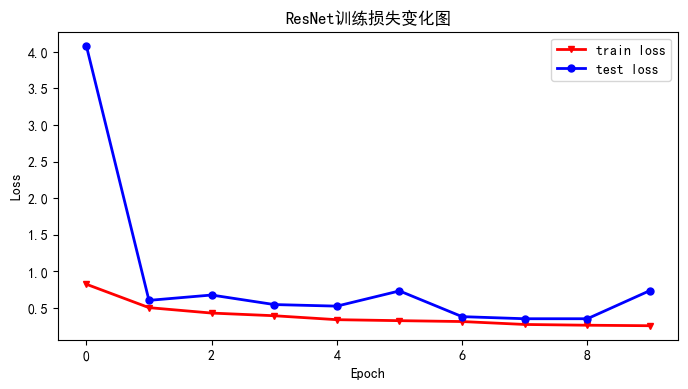

In [27]:
# 模型损失变化图
plot_loss(train_losses, test_losses, title="ResNet训练损失变化图")

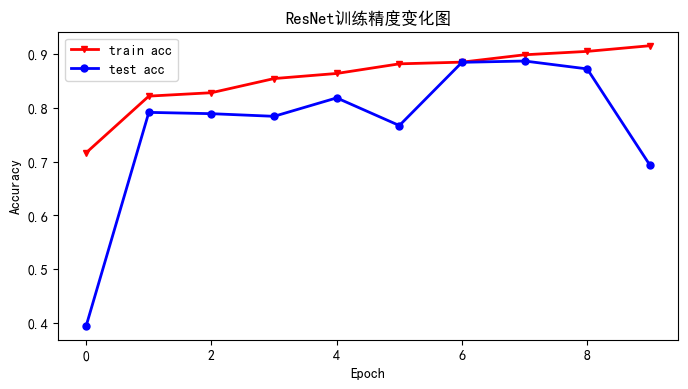

In [28]:
# 模型训练精度变化图
plot_acc(train_acc_list, test_acc_list, title='ResNet训练精度变化图')

第1张图片，原始类别为：['car'], 预测类别为：['car']
第2张图片，原始类别为：['truck'], 预测类别为：['bus']
第3张图片，原始类别为：['car'], 预测类别为：['car']
第4张图片，原始类别为：['car'], 预测类别为：['car']
第5张图片，原始类别为：['car'], 预测类别为：['car']


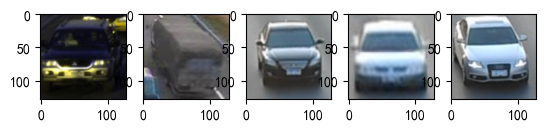

In [37]:
# 模型定性分析
classes = {'bus': 0, 'car': 1, 'truck': 2}
# 定义一个根据值索引键的函数
def get_keys_by_value(dictionary, target_value):
    keys_with_target_value = []
    for key, value in dictionary.items():
        if value == target_value:
            keys_with_target_value.append(key)
    return keys_with_target_value

checkpoint = torch.load('model_ResNet.pth')  # 替换为你的模型检查点文件路径
model.load_state_dict(checkpoint['model_state'])
model.eval()  # 设置模型为评估模式

# 抽样显示训练集中图片
fig, axes = plt.subplots(1, 5)
for i in range(5):
    # 使用模型进行预测
    rand_num = np.random.randint(1, 101)
    with torch.no_grad():
        # 随机选取图片输入
        output = model(test_dataset[i+rand_num][0].unsqueeze(0)).squeeze()
        prediction = torch.argmax(output)
        label = get_keys_by_value(classes, test_dataset[i+rand_num][1])
        predict = get_keys_by_value(classes, prediction)
        print(f'第{i+1}张图片，原始类别为：{label}, 预测类别为：{predict}')
        
    axes[i].imshow(transforms.ToPILImage()(test_dataset[i+rand_num][0]))

plt.show()